## Training a Support Vector Machine (SVM) algorithm to classify hand-written digit samples in the MNIST dataset.


Performed by
Ken Wood

ken@roarmarketingconcepts.com

In [0]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "svm"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

###Load the MNIST dataset...

Using TensorFlow backend.


11493376/11490434 [==============================] - 0s 0us/step


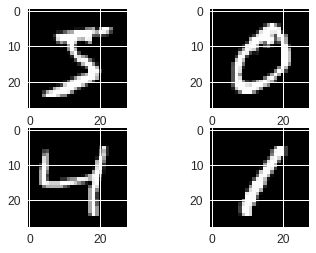

In [0]:
from keras.datasets import mnist

# load (downloaded if needed) the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# plot 4 images as gray scale
plt.subplot(221)
plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train[3], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

### We start the data processing by specifying the training and test sets and then shuffling the data.

In [0]:
np.random.seed(42)
rnd_idx_train = np.random.permutation(60000)
rnd_idx_test = np.random.permutation(10000)
X_train = X_train[rnd_idx_train]
print('X_train shape:',X_train.shape)
X_test = X_test[rnd_idx_test]
print('X_test shape:',X_test.shape)
y_train = y_train[rnd_idx_train]
print('y_train shape:',y_train.shape)
y_test = y_test[rnd_idx_test]
print('y_test shape:',y_test.shape)


X_train shape: (60000, 28, 28)
X_test shape: (10000, 28, 28)
y_train shape: (60000,)
y_test shape: (10000,)


### We need to flatten X_train and X_test from 3D to 2D before inputting them into the SVM models.


In [0]:
X_train = X_train.reshape(*X_train.shape[:1], -1)
print(X_train.shape)

(60000, 784)


In [0]:
X_test = X_test.reshape(*X_test.shape[:1], -1)
print(X_test.shape)

(10000, 784)


### Let's train the Linear Support Vector Classifier ('LinearSVC') which employs one-versus-all to classify all 10 digits. 

In [0]:
from sklearn.svm import LinearSVC

lin_svc_clf = LinearSVC(random_state=42)
lin_svc_clf.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)

### Let's make predictions on the training set and measure the accuracy between the predicted value $\hat{y}$ and actual value $y$.

In [0]:
from sklearn.metrics import accuracy_score

y_pred = lin_svc_clf.predict(X_train)
accuracy_score(y_train, y_pred)

0.8946

### 89.46% accuracy is not particularly good.  Let's try scaling the data.

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32))
X_test_scaled = scaler.transform(X_test.astype(np.float32))

lin_svc_clf.fit(X_train_scaled,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)

In [0]:
y_pred = lin_svc_clf.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.9222

### Well, we realized almost a 3% improvement by scaling the data. That's definitely better, but still not great for MNIST. If we want to use an SVM, we will have to use a kernel. Let's try an `SVC` with an RBF kernel (the default).

**Note**: We are using Scikit-Learn ≤ 0.19, the `SVC` class will use the One-vs-One (OvO) strategy by default, so we must explicitly set `decision_function_shape="ovr".

### Now, let's train a regular Support Vector Classifier (SVC) on 10000 training samples (to save computation processing time) and see what kind of results are produced.

In [0]:
from sklearn.svm import SVC

svm_clf = SVC(decision_function_shape="ovr", gamma="auto")
svm_clf.fit(X_train_scaled[:10000], y_train[:10000])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [0]:
y_pred = svm_clf.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.9475833333333333

### Let's fine tune the model by performing a Randomized search on the hyperparameters 'gamma' and 'C'.

In [0]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(svm_clf, param_distributions, n_iter=10, verbose=2)
rnd_search_cv.fit(X_train_scaled[:1000], y_train[:1000])

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=1.323581987935686, gamma=0.009416876185304573 .................
[CV] .. C=1.323581987935686, gamma=0.009416876185304573, total=   1.4s
[CV] C=1.323581987935686, gamma=0.009416876185304573 .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV] .. C=1.323581987935686, gamma=0.009416876185304573, total=   1.4s
[CV] C=1.323581987935686, gamma=0.009416876185304573 .................
[CV] .. C=1.323581987935686, gamma=0.009416876185304573, total=   1.4s
[CV] C=3.267681882860957, gamma=0.0041198777997363675 ................
[CV] . C=3.267681882860957, gamma=0.0041198777997363675, total=   1.3s
[CV] C=3.267681882860957, gamma=0.0041198777997363675 ................
[CV] . C=3.267681882860957, gamma=0.0041198777997363675, total=   1.3s
[CV] C=3.267681882860957, gamma=0.0041198777997363675 ................
[CV] . C=3.267681882860957, gamma=0.0041198777997363675, total=   1.3s
[CV] C=7.843574023603832, gamma=0.011455375062142517 .................
[CV] .. C=7.843574023603832, gamma=0.011455375062142517, total=   1.3s
[CV] C=7.843574023603832, gamma=0.011455375062142517 .................
[CV] .. C=7.843574023603832, gamma=0.011455375062142517, total=   1.3s
[CV] C=7.843574023603832, gamma=0.011455375062142517 .................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   56.8s finished


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd282703400>, 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd282703908>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [0]:
rnd_search_cv.best_estimator_

SVC(C=2.950743920248147, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0014406183951122377,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [0]:
rnd_search_cv.best_score_

0.859

### To improve this score, let's tune the SVC hyperparameters using the entire training dataset.

In [0]:
rnd_search_cv.best_estimator_.fit(X_train_scaled, y_train)

SVC(C=2.950743920248147, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0014406183951122377,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [0]:
y_pred = rnd_search_cv.best_estimator_.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.99555

### This accuracy number looks great! Now let's see how the model performs on the test set.

In [0]:
y_pred = rnd_search_cv.best_estimator_.predict(X_test_scaled)
accuracy_score(y_test, y_pred)

0.9724

### Not too bad, but it appears the model is slightly overfitting the training set.  We could adjust the hyperparameters slightly to fix this....  . However, since the accuracies between the train and test sets are quite close, we will consder the mission accomplished!